In [2]:
%matplotlib inline
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.pyplot as plt
import numpy as np
import keras 
from keras import backend as K
from keras.datasets import mnist
import keras.layers as L
from keras.models import Model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (x_train.shape[0], 28 * 28))
x_test = np.reshape(x_test, (x_test.shape[0], 28 * 28))

In [4]:
image_dim = 784
latent_dim = 2 # in order to produce visual represention of latent space
dim1 = 300
dim2 = 150

tf.reset_default_graph()
sess = tf.InteractiveSession()
K.set_session(sess)

nn_input = L.Input((image_dim,))

# reparametrization trick
def sample_latent(args):
    
    mu, log_var = args
    tensor_shape = K.shape(mu)
    batch_size, latent_dim = tensor_shape[0], tensor_shape[1]
    
    return mu + tf.exp(0.5 * log_var) * tf.random_normal((batch_size, latent_dim))

def create_encoder(dim1, dim2, latent_dim, input_dim):
    input_ = L.Input((input_dim, ))
    
    e_layer1 = L.Dense(dim1, activation='relu')(input_)
    e_layer1 = L.Dropout(0.1)(e_layer1)

    e_layer2 = L.Dense(dim2, activation='relu')(e_layer1)
    e_layer2 = L.Dropout(0.1)(e_layer2)

    e_layer3 = L.Dense(2 * latent_dim)(e_layer2)

    e_mu = L.Lambda(lambda h: h[:, :latent_dim])(e_layer3)
    e_log_var = L.Lambda(lambda h: h[:, latent_dim:])(e_layer3)

    z = L.Lambda(sample_latent, name='encoder')([e_mu, e_log_var])

    return Model(input_, [e_mu, e_log_var, z], name='encoder')

def create_decoder(dim1, dim2, latent_dim, output_dim):
    
    input_ = L.Input((latent_dim, ))
    
    d_layer1 = L.Dense(dim1, activation='relu')(input_)
    d_layer1 = L.Dropout(0.1)(d_layer1)
    
    d_layer2 = L.Dense(dim2, activation='relu')(d_layer1)
    d_layer2 = L.Dropout(0.1)(d_layer2)
    
    d_layer3 = L.Dense(output_dim, activation='sigmoid')(d_layer2)
    
    return Model(input_, d_layer3)
    
encoder = create_encoder(dim1, dim2, latent_dim, image_dim)

encoder_output = encoder(nn_input)

encoder_mu = encoder_output[0]
encoder_log_var = encoder_output[1]

decoder = create_decoder(dim2, dim1, latent_dim, image_dim)

vae = Model(nn_input, decoder(encoder_output[2]))

nn_ouput = vae(nn_input)

In [5]:
# kullback leibler divergence
def kl(e_mu, e_log_var):
    
    kl_i = 0.5 * tf.reduce_sum(
            tf.pow(e_mu, 2) + 
            tf.exp(e_log_var) - 
            e_log_var - 
            1, 
        axis=1)
    
    return kl_i

# reconstruction error
def reconstruction_error(x, d_p):
    d_p = tf.clip_by_value(d_p, clip_value_min=1e-06, clip_value_max=1-1e-06)
    
    re_i = tf.reduce_sum(x * K.log(d_p) + (1 - x) * K.log(1 - d_p), axis=1)
    
    return re_i

def lowebound(x, d_p, e_mu, e_log_var):
    return K.mean(reconstruction_error(x, d_p) - kl(e_mu, e_log_var))

lb = lowebound(nn_input, nn_ouput, encoder_mu, encoder_log_var)

In [6]:
vae.compile(
    optimizer=keras.optimizers.Adam(lr=1e-03), 
    loss = lambda x, y: -lb
)

In [7]:
vae.fit(
    x_train, 
    x_train,
    epochs=50,
    batch_size=100,
    validation_data=(x_test, x_test), 
    verbose=1
)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 5s 88us/step - loss: 189.0856 - val_loss: 168.4497
Epoch 2/50
60000/60000 [==============================] - 5s 86us/step - loss: 166.8686 - val_loss: 161.0953
Epoch 3/50
60000/60000 [==============================] - 5s 88us/step - loss: 161.5095 - val_loss: 157.3194
Epoch 4/50
60000/60000 [==============================] - 5s 84us/step - loss: 158.3483 - val_loss: 154.3552
Epoch 5/50
60000/60000 [==============================] - 5s 84us/step - loss: 156.3386 - val_loss: 152.4125
Epoch 6/50
60000/60000 [==============================] - 5s 80us/step - loss: 154.9139 - val_loss: 151.4137
Epoch 7/50
60000/60000 [==============================] - 5s 89us/step - loss: 153.7334 - val_loss: 150.6879
Epoch 8/50
60000/60000 [==============================] - 5s 85us/step - loss: 152.8865 - val_loss: 149.4084
Epoch 9/50
60000/60000 [==============================] - 5s 89us/step - loss:

Checking reconstruction power on training set


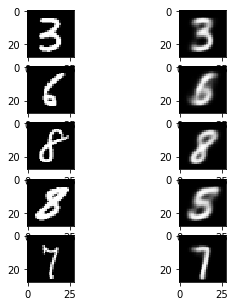

In [8]:
print("Checking reconstruction power on training set")
fig = plt.figure(figsize=(5, 5))

for i in range(5):
    example_id = np.random.randint(0, x_train.shape[0])
    example_image = np.reshape(x_train[example_id], (28, 28))
    pred = vae.predict(np.expand_dims(x_train[example_id], axis=0))
    
    fig.add_subplot(5, 2, 2 * i + 1)
    plt.imshow(example_image, cmap='Greys_r')
    fig.add_subplot(5, 2, 2 * (i + 1))
    plt.imshow(np.reshape(pred, (28, 28)), cmap='Greys_r')

Checking reconstruction power on testing set


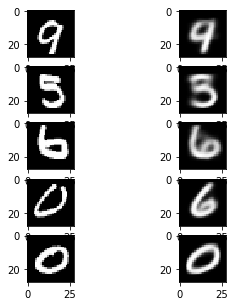

In [9]:
print("Checking reconstruction power on testing set")
fig = plt.figure(figsize=(5, 5))

for i in range(5):
    example_id = np.random.randint(0, x_test.shape[0])
    example_image = np.reshape(x_test[example_id], (28, 28))
    pred = vae.predict(np.expand_dims(x_test[example_id], axis=0))
    
    fig.add_subplot(5, 2, 2 * i + 1)
    plt.imshow(example_image, cmap='Greys_r')
    fig.add_subplot(5, 2, 2 * (i + 1))
    plt.imshow(np.reshape(pred, (28, 28)), cmap='Greys_r')

In [10]:
Z = np.random.normal(loc=[0, 0], scale=[1, 1], size=(100, 2))
d = decoder.predict(Z)

In [11]:
# https://stackoverflow.com/questions/22566284/matplotlib-how-to-plot-images-instead-of-points
def imscatter(x, y, image, ax=None, zoom=1):
    if ax is None:
        ax = plt.gca()
    try:
        image = plt.imread(image)
    except TypeError:
        # Likely already an array...
        pass
    im = OffsetImage(image, zoom=zoom)
    x, y = np.atleast_1d(x, y)
    artists = []
    for x0, y0 in zip(x, y):
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

#### Samples from 2-D latent space

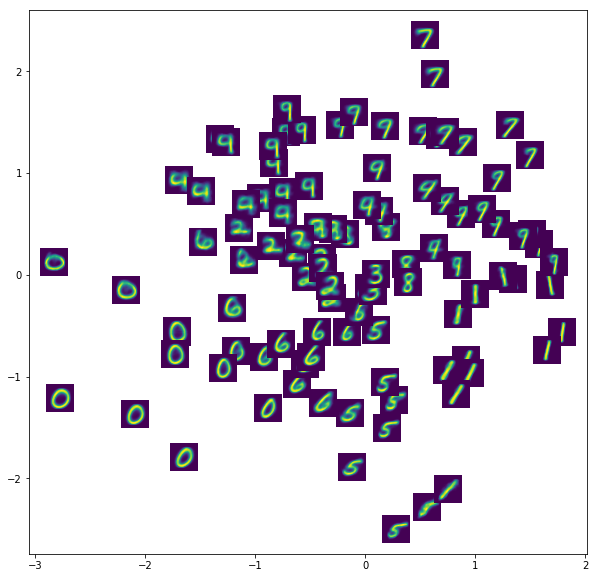

In [12]:
fig = plt.figure(figsize=(10, 10))
ax = fig.gca()
for i, (x, y) in enumerate(Z):
    imscatter(x, y, np.reshape(d[i], (28, 28)), ax);

#### As can be seen above, these two coordinates have decent predictive power. We can try to classify digits based on the latent space

In [13]:
train_encoder_ouput = encoder.predict(x_train)
train_encoder_mu = train_encoder_ouput[0]

test_encoder_output = encoder.predict(x_test)
test_encoder_mu = test_encoder_output[0]

In [14]:
lr = LogisticRegression()
knn = KNeighborsClassifier(5)
sc = StandardScaler()

knn_train = sc.fit_transform(train_encoder_mu)
knn_test = sc.transform(test_encoder_mu)

lr.fit(train_encoder_mu, y_train)
knn.fit(knn_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [15]:
lr_train_pred = lr.predict(train_encoder_mu)
knn_train_pred = knn.predict(knn_train)

print('Train accuracy lr: {}'.format(accuracy_score(y_train, lr_train_pred)))
print('Train accuracy knn: {}'.format(accuracy_score(y_train, knn_train_pred)))

Train accuracy lr: 0.6292333333333333
Train accuracy knn: 0.8424833333333334


In [16]:
lr_test_pred = lr.predict(test_encoder_mu)
knn_test_pred = knn.predict(knn_test)

print('Test accuracy lr: {}'.format(accuracy_score(y_test, lr_test_pred)))
print('Test accuracy knn: {}'.format(accuracy_score(y_test, knn_test_pred)))

Test accuracy lr: 0.6228
Test accuracy knn: 0.7866


#### Some digits can be quite difficult to decipher. This should be also reflected in standard deviation in variational distribution. Let's have a look

In [17]:
train_encoder_std = np.exp(0.5 * train_encoder_ouput[1])
test_encoder_std = np.exp(0.5 * test_encoder_output[1])

In [18]:
lr_test_pred_proba = lr.predict_proba(test_encoder_mu)

In [19]:
true_classes_prob = lr_test_pred_proba[np.arange(lr_test_pred_proba.shape[0]), y_test]

In [20]:
min_id = np.argmin(true_classes_prob)
print('example id: {}, prob: {}, true class: {}'.format(min_id, true_classes_prob[min_id],
                                                       y_test[min_id]))

example id: 6597, prob: 6.227494478330792e-06, true class: 0


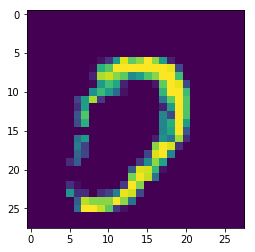

In [21]:
plt.imshow(np.reshape(x_test[min_id], (28, 28)))

In [22]:
print('Logistic regression estimate: {}'.format(np.argmax(lr_test_pred_proba[min_id])))

Logistic regression estimate: 7


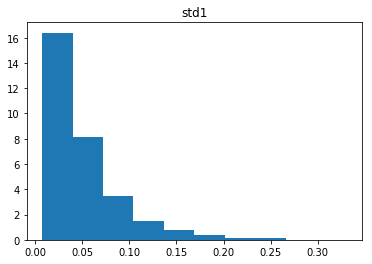

In [23]:
plt.hist(test_encoder_std[:, 0], density=True)
plt.title('std1');

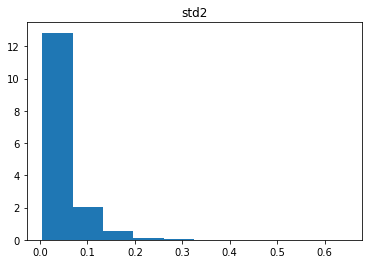

In [24]:
plt.hist(test_encoder_std[:, 1], density=True)
plt.title('std2');

In [25]:
# Looking at the histograms (above) of these parameters, this example is not an outlier. 
# Nonetheless, the information about standard deviations might be helpful
std1, std2 = test_encoder_std[min_id]
print('std1: {}, str2: {}'.format(std1, std2))
print('{} of test examples has lower std1'.format(np.mean(test_encoder_std[:, 0] < std1)))
print('{} of test examples has lower std2'.format(np.mean(test_encoder_std[:, 1] < std2)))

std1: 0.06054424121975899, str2: 0.09285066276788712
0.7369 of test examples has lower std1
0.9133 of test examples has lower std2


In [26]:
lr = LogisticRegression()
knn = KNeighborsClassifier(5)
sc = StandardScaler()

knn_train = sc.fit_transform(np.hstack([train_encoder_mu, train_encoder_std]))
knn_test = sc.transform(np.hstack([train_encoder_mu, train_encoder_std]))

lr.fit(np.hstack([train_encoder_mu, train_encoder_std]), y_train)
knn.fit(np.hstack([train_encoder_mu, train_encoder_std]), y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [27]:
lr_train_pred = lr.predict(np.hstack([train_encoder_mu, train_encoder_std]))
knn_train_pred = knn.predict(np.hstack([train_encoder_mu, train_encoder_std]))

print('Train accuracy lr: {}'.format(accuracy_score(y_train, lr_train_pred)))
print('Train accuracy knn: {}'.format(accuracy_score(y_train, knn_train_pred)))

Train accuracy lr: 0.6648166666666666
Train accuracy knn: 0.8490166666666666


In [28]:
lr_test_pred = lr.predict(np.hstack([test_encoder_mu, test_encoder_std]))
knn_test_pred = knn.predict(np.hstack([test_encoder_mu, test_encoder_std]))

print('Test accuracy lr: {}'.format(accuracy_score(y_test, lr_test_pred)))
print('Test accuracy knn: {}'.format(accuracy_score(y_test, knn_test_pred)))

Test accuracy lr: 0.6614
Test accuracy knn: 0.7946
